# Backtesting for investment strategies

# Planejamento da Solução

## Input - Entrada

### Problema de Negócio

1. Selecionar uma estratégia de compra e venda para as empresas do setor de Petróleo e Gás e que lidam com a **Exploração, Refino e Distribuição**


## Output - Saída
 
1. Destacar a estratégia com melhor desempenho médio com métricas, pontos positivos e negativos.
2. Tabelas e gráficos com informações/insights referentes ao setor de petróleo e gás.


## Tasks - Processo

#
1. Coletar dados das empresas de exploração, refino e distribuição da bovespa do período de 1 ano.

    - Quais são as informações relevantes?
      - Fatores internos:
        1. Cotação (Interno e externo)
        2. Gestão
        3. Políticas internas
        4. Colaboradores
        5. Equidade
        6. Meio Ambiente
        7. Stakeholders
      

      - Fatores externos:
        1. Governo
        2. Shareholders
        3. Concorrência
        4. Fatia de mercado
        5. Segmento


#
2. Visualizar suas cotações diárias em gráficos e tabelas

#
3. Realizar testes de estratégias via backtest.
  - Conhecer e desenvolver backtesting (bt package)

#
4. Realizar análise exploratória com os dados das empresas e cotações e extrair insights
    - Coletar informações vide passo 1.

#
5. Desenvolver novas estratégias e testa-las
    - Estudar possíveis indicadores:
      1. Médias móveis
      2. Volume
      3. Fibbonachi
      4. Suporte + resistência
      5. Stock RSI
      6. Previsão de ações via ML.

#
6. Comparar os testes por ganhos, perdas, alocação, etc.
    - Quais as melhores métricas de comparação?
      1. Retorno (diário/semanal/mensal/anual)
      2. Impacto da estratégia sobre volatividade (redução de risco).

#
7. Publicar informações no streamlit via cloud.

# 0.0 Imports

In [1]:
import bt
import investpy
import btalib as bta

import pickle
#import warnings
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader

from tabulate            import tabulate
from matplotlib          import pyplot as plt
from IPython.display     import Image
from matplotlib.gridspec import GridSpec

f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    '''Settings for pandas, matplotlib and warnings'''
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    # Configures pandas for number of decimal places
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    # Ignore future warnings
    #warnings.filterwarnings('ignore')
    
    sns.set()



def make_bbands(data, abb):
    '''Creates new dataframe with buy and sell calculations based on the bolling band strategy '''
    df_signal = pd.DataFrame()
    df_bb = pd.DataFrame()

    # Select close for shares
    df_aux = data
    df_bb = df_aux[[abb]]

    # Calculate bbands
    df_signal = bta.bbands(df_aux[[abb]], period=20, devs=2.0).df

    df_bb = pd.concat([df_bb, df_signal], axis=1)

    # Create signal for buy or sell
    df_bb['signal'] = df_bb.apply(lambda x: -1.0 if x[abb] > x['top'] else 1.0 if x[abb] <= x['bot'] else 0.0, axis=1)
    df_bb = df_bb.fillna(0) # remove nan for first 20 days

    return df_bb



def btesting(data, abb):
    '''Make back testing with bolling band'''
    # Aux df with same name of column for buy or sell
    df_aux = pd.DataFrame()
    df_aux['signal'] = data[abb][[abb +'.SA']].copy()

    # Make back testing
    bbands = bt.Strategy(abb+' bbands', [bt.algos.WeighTarget(data[abb][['signal']]), bt.algos.Rebalance()])

    btest = bt.Backtest(bbands, df_aux)

    return btest

In [3]:
jupyter_settings()

## 0.2 Load Data

In [4]:
stock_price = ['RRRP3.SA', 'CSAN3.SA', 'DMMO3.SA', 'ENAT3.SA', 'PRIO3.SA', 'PETR3.SA', 'RECV3.SA', 'RPMG3.SA', 'UGPA3.SA', 'VBBR3.SA', 'BZ=F', 'NG=F', 'BRL=X']

# Collect data for stock price and economic aspects
df_stock_price = pandas_datareader.data.get_data_yahoo(['RRRP3.SA', 'CSAN3.SA', 'DMMO3.SA', 'ENAT3.SA', 'PRIO3.SA', 'PETR3.SA', 'RECV3.SA', 'RPMG3.SA', 'UGPA3.SA', 'VBBR3.SA'], start='11-01-2020', end='10-10-2022')[['Close', 'Adj Close']]

df_commodities = pandas_datareader.data.get_data_yahoo(['BZ=F', 'NG=F'], start='11-01-2020', end='10-10-2022')[['Close']]

df_ipca = investpy.economic_calendar(countries=['brazil'], from_date='01/11/2020', to_date='10/10/2022')
df_ipca = df_ipca[['date', 'event', 'actual']][df_ipca['event'].str.contains('Brazilian IPCA Inflation Index SA')]

df_cambio = pandas_datareader.data.get_data_yahoo('BRL=X', start='11-01-2020', end='10-10-2022')[['Close']]

# Make data frame with all infos for analysis
df_raw  = pandas_datareader.data.get_data_yahoo(stock_price, start='11-01-2020', end='10-10-2022')[['Close', 'Adj Close']]

# 1.0 Descrição dos dados

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head().T

Date                 2020-11-02  2020-11-03  2020-11-04  2020-11-05  \
Attributes Symbols                                                    
Close      RRRP3.SA         NaN         NaN         NaN         NaN   
           CSAN3.SA         NaN       16.58       16.70       18.39   
           DMMO3.SA         NaN        1.15        1.16        1.19   
           ENAT3.SA         NaN        9.09        9.00        9.10   
           PRIO3.SA         NaN        6.49        6.44        6.47   
           PETR3.SA         NaN       19.75       19.84       19.94   
           RECV3.SA         NaN         NaN         NaN         NaN   
           RPMG3.SA         NaN        2.56        2.64        2.69   
           UGPA3.SA         NaN       16.59       17.16       19.75   
           VBBR3.SA         NaN       19.15       19.82       20.94   
           BZ=F           37.46       39.71       41.23       40.93   
           NG=F            3.24        3.06        3.05        2.94   
           BRL=X           5.74        5.74        5.75        5.66   
Adj Close  RRRP3.SA         NaN         NaN         NaN         NaN   
           CSAN3.SA         NaN       15.43       15.54       17.11   
           DMMO3.SA         NaN        1.15        1.16        1.19   
           ENAT3.SA         NaN        8.30        8.22        8.31   
           PRIO3.SA         NaN        6.49        6.44        6.47   
           PETR3.SA         NaN       11.11       11.16       11.22   
           RECV3.SA         NaN         NaN         NaN         NaN   
           RPMG3.SA         NaN        2.56        2.64        2.69   
           UGPA3.SA         NaN       15.53       16.06       18.48   
           VBBR3.SA         NaN       16.79       17.38       18.36   
           BZ=F           37.46       39.71       41.23       40.93   
           NG=F            3.24        3.06        3.05        2.94   
           BRL=X           5.74        5.74        5.75        5.66   

Date                 2020-11-06  
Attributes Symbols               
Close      RRRP3.SA         NaN  
           CSAN3.SA       18.23  
           DMMO3.SA        1.19  
           ENAT3.SA        9.11  
           PRIO3.SA        6.80  
           PETR3.SA       19.87  
           RECV3.SA         NaN  
           RPMG3.SA        2.70  
           UGPA3.SA       19.94  
           VBBR3.SA       21.14  
           BZ=F           39.45  
           NG=F            2.89  
           BRL=X           5.52  
Adj Close  RRRP3.SA         NaN  
           CSAN3.SA       16.96  
           DMMO3.SA        1.19  
           ENAT3.SA        8.32  
           PRIO3.SA        6.80  
           PETR3.SA       11.18  
           RECV3.SA         NaN  
           RPMG3.SA        2.70  
           UGPA3.SA       18.66  
           VBBR3.SA       18.53  
           BZ=F           39.45  
           NG=F            2.89  
           BRL=X           5.52

## 1.1 Rename Columns

In [7]:
df1.columns

MultiIndex([(    'Close', 'RRRP3.SA'),
            (    'Close', 'CSAN3.SA'),
            (    'Close', 'DMMO3.SA'),
            (    'Close', 'ENAT3.SA'),
            (    'Close', 'PRIO3.SA'),
            (    'Close', 'PETR3.SA'),
            (    'Close', 'RECV3.SA'),
            (    'Close', 'RPMG3.SA'),
            (    'Close', 'UGPA3.SA'),
            (    'Close', 'VBBR3.SA'),
            (    'Close',     'BZ=F'),
            (    'Close',     'NG=F'),
            (    'Close',    'BRL=X'),
            ('Adj Close', 'RRRP3.SA'),
            ('Adj Close', 'CSAN3.SA'),
            ('Adj Close', 'DMMO3.SA'),
            ('Adj Close', 'ENAT3.SA'),
            ('Adj Close', 'PRIO3.SA'),
            ('Adj Close', 'PETR3.SA'),
            ('Adj Close', 'RECV3.SA'),
            ('Adj Close', 'RPMG3.SA'),
            ('Adj Close', 'UGPA3.SA'),
            ('Adj Close', 'VBBR3.SA'),
            ('Adj Close',     'BZ=F'),
            ('Adj Close',     'NG=F'),
            ('Adj Close',

In [8]:
old_cols = ['Close', 'Adj Close']

df1.columns = df1.columns.set_levels(['close', 'adj_close'], level=0) # 'adj_close', 'close', 'high', 'low', 'open', 'volume'

## 1.2 Data Dimension

In [9]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 565
Number of columns: 26


## 1.3 Data Types

In [10]:
df1.dtypes

Attributes  Symbols 
adj_close   RRRP3.SA    float64
            CSAN3.SA    float64
            DMMO3.SA    float64
            ENAT3.SA    float64
            PRIO3.SA    float64
            PETR3.SA    float64
            RECV3.SA    float64
            RPMG3.SA    float64
            UGPA3.SA    float64
            VBBR3.SA    float64
            BZ=F        float64
            NG=F        float64
            BRL=X       float64
close       RRRP3.SA    float64
            CSAN3.SA    float64
            DMMO3.SA    float64
            ENAT3.SA    float64
            PRIO3.SA    float64
            PETR3.SA    float64
            RECV3.SA    float64
            RPMG3.SA    float64
            UGPA3.SA    float64
            VBBR3.SA    float64
            BZ=F        float64
            NG=F        float64
            BRL=X       float64
dtype: object

## 1.4 Change Data Types

In [11]:
df_ipca['date'] = pd.to_datetime(df_ipca['date'])

df_ipca['actual'] = df_ipca['actual'].replace('%', '', regex=True)

df_ipca['actual'] = df_ipca['actual'].astype('float64')

df_ipca['month_year'] = df_ipca['date'].dt.strftime('%Y-%m')

## 1.5 Check NA

In [12]:
df1.isna().sum()

Attributes  Symbols 
adj_close   RRRP3.SA     92
            CSAN3.SA     84
            DMMO3.SA     84
            ENAT3.SA     84
            PRIO3.SA     84
            PETR3.SA     84
            RECV3.SA    205
            RPMG3.SA     84
            UGPA3.SA     84
            VBBR3.SA     84
            BZ=F         76
            NG=F         74
            BRL=X        58
close       RRRP3.SA     92
            CSAN3.SA     84
            DMMO3.SA     84
            ENAT3.SA     84
            PRIO3.SA     84
            PETR3.SA     84
            RECV3.SA    205
            RPMG3.SA     84
            UGPA3.SA     84
            VBBR3.SA     84
            BZ=F         76
            NG=F         74
            BRL=X        58
dtype: int64

## 1.6 Replace NA

In [13]:
df1 = df1.fillna(method='ffill') # uses the last quotation to fill days with no market movement
df1 = df1.drop('2020-11-02') # Drop first day

df1.isna().sum() # RECV3 open market in 05/2021

Attributes  Symbols 
adj_close   RRRP3.SA      8
            CSAN3.SA      0
            DMMO3.SA      0
            ENAT3.SA      0
            PRIO3.SA      0
            PETR3.SA      0
            RECV3.SA    136
            RPMG3.SA      0
            UGPA3.SA      0
            VBBR3.SA      0
            BZ=F          0
            NG=F          0
            BRL=X         0
close       RRRP3.SA      8
            CSAN3.SA      0
            DMMO3.SA      0
            ENAT3.SA      0
            PRIO3.SA      0
            PETR3.SA      0
            RECV3.SA    136
            RPMG3.SA      0
            UGPA3.SA      0
            VBBR3.SA      0
            BZ=F          0
            NG=F          0
            BRL=X         0
dtype: int64

## 1.7 Descriptive Statistical

### 1.7.1 Numerical Attributes

In [14]:
# Central tendency and Dispersion
d1 = pd.DataFrame (df1.apply( lambda x: x.max() - x.min() )).T
d2 = df1.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concatenate
m2 = pd.concat([d1, d2]).T.reset_index()
m2.columns = ['attributes', 'symbols', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
m2 = m2[['attributes', 'symbols', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

m2[m2['attributes'] == 'adj_close'].sort_values(['range', 'std'])

,attributes,symbols,min,max,range,mean,median,std,skew,kurtosis
12,adj_close,BRL=X,4.59,5.87,1.28,5.27,5.25,0.25,-0.25,-0.20
2,adj_close,DMMO3.SA,0.44,1.86,1.42,1.09,0.94,0.36,0.38,-0.98
7,adj_close,RPMG3.SA,1.87,6.32,4.45,3.07,2.88,0.88,1.10,0.87
11,adj_close,NG=F,2.31,9.68,7.38,4.90,4.34,2.05,0.65,-0.79
1,adj_close,CSAN3.SA,15.40,27.20,11.80,21.39,21.62,2.28,-0.01,-0.43
9,adj_close,VBBR3.SA,16.13,29.46,13.33,22.19,22.14,3.22,0.23,-0.46
8,adj_close,UGPA3.SA,11.60,24.98,13.38,16.44,14.81,3.66,0.60,-1.06
3,adj_close,ENAT3.SA,9.00,23.85,14.85,15.61,15.29,3.14,0.57,-0.04
6,adj_close,RECV3.SA,13.56,30.00,16.44,20.95,20.30,4.41,0.17,-1.27
5,adj_close,PETR3.SA,19.75,39.85,20.10,30.16,29.60,4.43,-0.02,-0.80


- The range and standard deviation create indications of stock volatility, however, it would be important to normalize the data to get a better indication.

In [15]:
# Check range of days
df_aux = df1.reset_index()

(df_aux['Date'].max() - df_aux['Date'].min()).days

707

# 2.0 Feature Engineering

Dados:

 - Cotação do barril brent (referência para mercado europeu, asiatico e brasileiro)
 - Início da guerra: "24 de fevereiro de 2022"
 - Indice de inflação ipca
 - Cotação do cambio
 - Principais datas do covid: https://glamour.globo.com/bem-estar/saude/noticia/2021/03/linha-do-tempo-da-covid-19-os-principais-fatos-da-pandemia-no-brasil.ghtml
 - Produção de petroleo
 - Demanda do setor

In [16]:
df2 = df1['adj_close'].copy()

## 2.1 MindMap Hypothesis

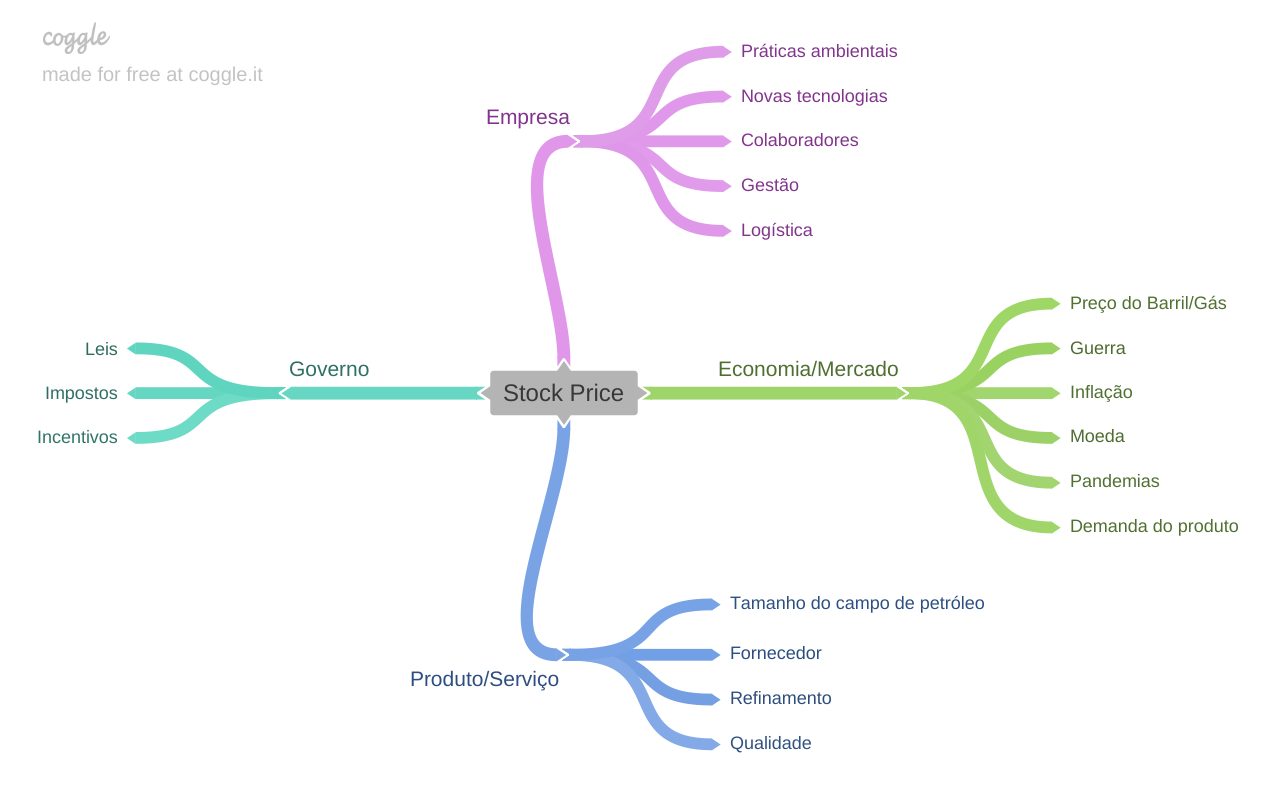

In [17]:
Image('../reports/Stock_Price_mindmap.png')

## 2.2 Lista de hipóteses empresa

1. Empresas que aplicam praticas ambientais tiveram em média um crescimento ano a ano superior a 10% no preço das ações em relação as que não possuem.
2. Empresas que utilizam de tecnologias mais recentes possuem em média um P/L 30% superior as que não utilizam.
3. Empresas com mais colaboradores tiveram em média um descresimo de 5% no preço das ações em relação as que possuem menos.
4. Empresas com maior equidade nas cadeiras de liderença (50/50) tiveram em média um aumento de 25% no preço das ações.
5. Empresas com logística própria possuem em média o P/L 20% inferior.

## 2.3 Lista de hipóteses Economia/Mercado

1. A cada 50% de aumento do preço do barril de petroleo a cotação das ações das empresas de petroleo sobe em média 30%.
2. A cada 40% de aumento do preço do gás natural a cotação das ações das empresas de petroleo sobe em média 10%.
3. Início de períodos de guerras correspondem a um aumento médio de 40% das ações. 
4. A medida de a inflação acumulada cresce 1% as ações caem em média 5%.
5. Em períodos trimestrais onde o Real desvaloriza em media 20% as ações valorizam em média 10%.
6. Para cada 10% de aumento de casos de Covid as ações caem em média 3%.
7. A medida que a demanda do setor de pretoleo e derivados aumenta em média 10% as ações aumentam em média 15%.

## 2.4 Lista de hipóteses Produto/Serviço

1. Para cada 1.000 m³ de poço de petroleo pertencente a empresa o P/L aumenta 0,5%.
2. Empresas com processo de refinamento interno possuem um aumento anual médio de 20% das ações em relação as demais.

## 2.5 Lista de hipóteses Governo

1. A medida que impostos caem 10% as ações das empresas sobem em média 5%.
2. Empresas onde o governo possui participação acionário possuem em média 20% a mais de P/L.
3. Petrobras cresce em média 20% a mais nas ações do que as demais

## 2.6 Lista de hipóteses Tempo

Hipoteses:

Anualmente o preço das ações de petroleo sobem 10% a mais do que o preço do barril de petroleo

1. 
2. 

## 2.7 Lista final de hipóteses

1. A cada 50% de aumento do preço do barril de petroleo a cotação das ações das empresas de petroleo sobe em média 30%.
2. A cada 40% de aumento do preço do gás natural a cotação das ações das empresas de petroleo sobe em média 10%.
3. Início de períodos de guerras correspondem a um aumento médio de 40% das ações. 
4. A medida de a inflação acumulada cresce 1% as ações caem em média 5%.
5. Em períodos trimestrais onde o Real desvaloriza em media 20% as ações valorizam em média 10%.


## 2.8 Feature Engineering

In [18]:
# Features for time
df2 = df2.reset_index()

df2['day'] = df2['Date'].dt.day

df2['month'] = df2['Date'].dt.month

df2['year'] = df2['Date'].dt.year

df2['day_of_week'] = df2['Date'].dt.day_of_week

df2['week_of_year'] = df2['Date'].dt.isocalendar().week

df2['month_year'] = df2['Date'].dt.strftime('%Y-%m')

df2 = df2.set_index('Date')

In [19]:
df_profit = pd.DataFrame()

for i in stock_price:
    df_profit[i+'_profit'] = df2[i] / df2[i].shift() * 100 - 100

# Average price of oil company shares
df_profit['mean_profit'] = df_profit.iloc[:,:10].mean(axis=1)

df2 = pd.concat([df2, df_profit], axis=1)


df_ipca['cumsum'] = df_ipca['actual'].cumsum()

df_ipca['ipca_standt_cumsum'] = df_ipca['cumsum'] / df_ipca['cumsum'].shift() * 100 - 100

In [20]:
# ------------------ Make features for bbands in each shares ---------------------------------------
df_RRRP3 = make_bbands(data= df2, abb = 'RRRP3.SA')

df_CSAN3 = make_bbands(data= df2, abb = 'CSAN3.SA')

df_DMMO3 = make_bbands(data= df2, abb = 'DMMO3.SA')

df_ENAT3 = make_bbands(data= df2, abb = 'ENAT3.SA')

df_PRIO3 = make_bbands(data= df2, abb = 'PRIO3.SA')

df_PETR3 = make_bbands(data= df2, abb = 'PETR3.SA')

df_RECV3 = make_bbands(data= df2, abb = 'RECV3.SA')

df_RPMG3 = make_bbands(data= df2, abb = 'RPMG3.SA')

df_UGPA3 = make_bbands(data= df2, abb = 'UGPA3.SA')

df_VBBR3 = make_bbands(data= df2, abb = 'VBBR3.SA')

# Concat all results
df2_new = pd.concat([df_RRRP3, df_CSAN3, df_DMMO3, df_ENAT3, df_PRIO3, df_PETR3, df_RECV3, df_RPMG3, df_UGPA3, df_VBBR3], keys=['RRRP3', 'CSAN3', 'DMMO3', 'ENAT3', 'PRIO3', 'PETR3', 'RECV3', 'RPMG3', 'UGPA3', 'VBBR3'], axis=1)

# 3.0 Portfolio Strategy

In [21]:
df3 = df2_new.copy()

- Indice Bovespa (BOVA11) como Baseline
- Simular indice de petroleo com uma carteira com pesos iguais como baseline
- Estratégia: hold como baseline

## 3.1 Buy & Hold (Baseline)

## 3.2 Rebalancing

## 3.3 Bollinger Bands

In [22]:
btest1 = btesting(df3 ,'RRRP3')

btest2 = btesting(df3 ,'CSAN3')

btest3 = btesting(df3 ,'DMMO3')

btest4 = btesting(df3 ,'ENAT3')

btest5 = btesting(df3 ,'PRIO3')

btest6 = btesting(df3 ,'PETR3')

btest7 = btesting(df3 ,'RECV3')

btest8 = btesting(df3 ,'RPMG3')

btest9 = btesting(df3 ,'UGPA3')

btest10 = btesting(df3 ,'VBBR3')


results = bt.run(btest1, btest2, btest3, btest4, btest5 , btest6, btest7, btest8, btest9, btest10)

results.display()

f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in divide
  res = np.divide(er.mean(), std)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\backtesting_strategies\lib\site-pack

Stat                 RRRP3 bbands    CSAN3 bbands    DMMO3 bbands    ENAT3 bbands    PRIO3 bbands    PETR3 bbands    RECV3 bbands    RPMG3 bbands    UGPA3 bbands    VBBR3 bbands
-------------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------
Start                2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02      2020-11-02
End                  2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11      2022-10-11
Risk-free rate       0.00%           0.00%           0.00%           0.00%           0.00%           0.00%           0.00%           0.00%           0.00%           0.00%

Total Return         -1.95%          -12.29%         70.92%          21.42%          1.33%           11.82%          9

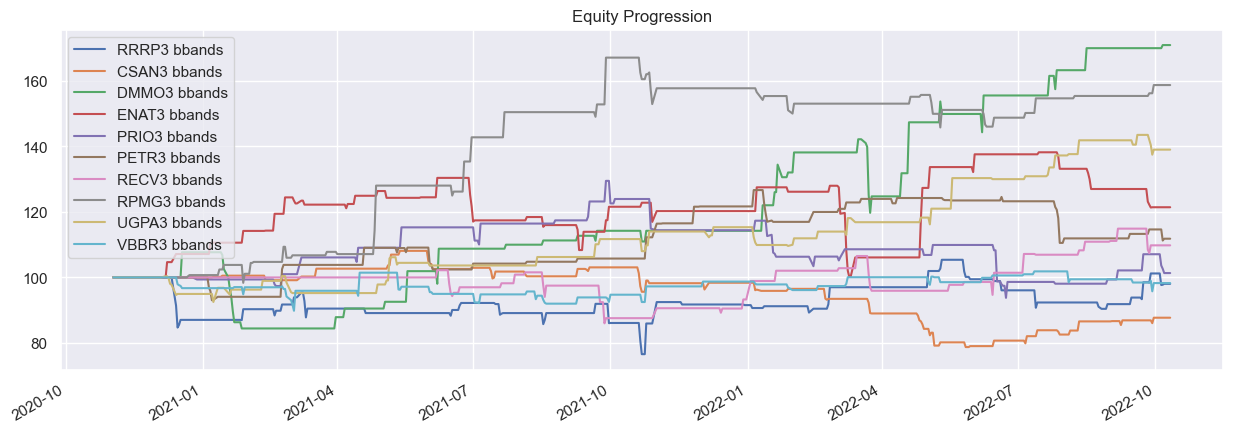

In [23]:
results.plot();

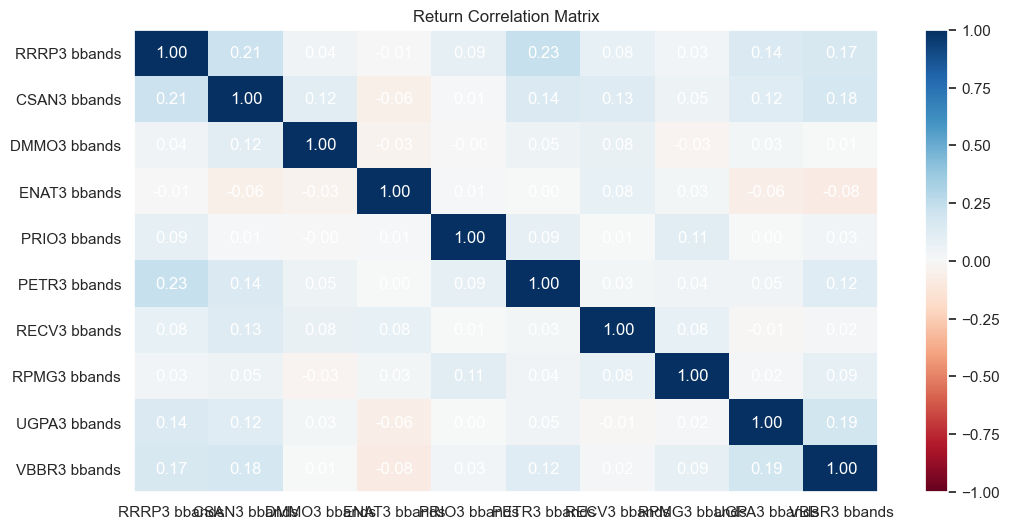

In [24]:
results.plot_correlation();

# 4.0 Análise exploratória dos dados

In [25]:
df4 = df2.copy()

## 4.1 Análise Univariada

### 4.1.2 Numerical Variable

- Pandas profiling

## 4.2 Análise Bivariada

In [26]:
aux = df4[['day', 'month', 'year', 'day_of_week', 'month_year', 'mean_profit', 'BZ=F_profit',
       'NG=F_profit', 'BRL=X_profit']]

aux.head()

,day,month,year,day_of_week,month_year,mean_profit,BZ=F_profit,NG=F_profit,BRL=X_profit
Date,,,,,,,,,
2020-11-03,3,11,2020,1,2020-11,NaN,NaN,NaN,NaN
2020-11-04,4,11,2020,2,2020-11,1.30,3.83,-0.42,0.24
2020-11-05,5,11,2020,3,2020-11,4.68,-0.73,-3.41,-1.60
2020-11-06,6,11,2020,4,2020-11,0.78,-3.62,-1.84,-2.47
2020-11-09,9,11,2020,0,2020-11,3.14,7.48,-1.00,-2.91


### H1. O crescimento médio do preço do barril de petroleo anual (YoY) é 20% maior do que os das ações das empresas petrolíferas 
**FALSE** O barril de petroleo em média está 8,82% inferior em comparação ao crescimento médio das empresas petrolíferas

<Figure size 2200x800 with 0 Axes>

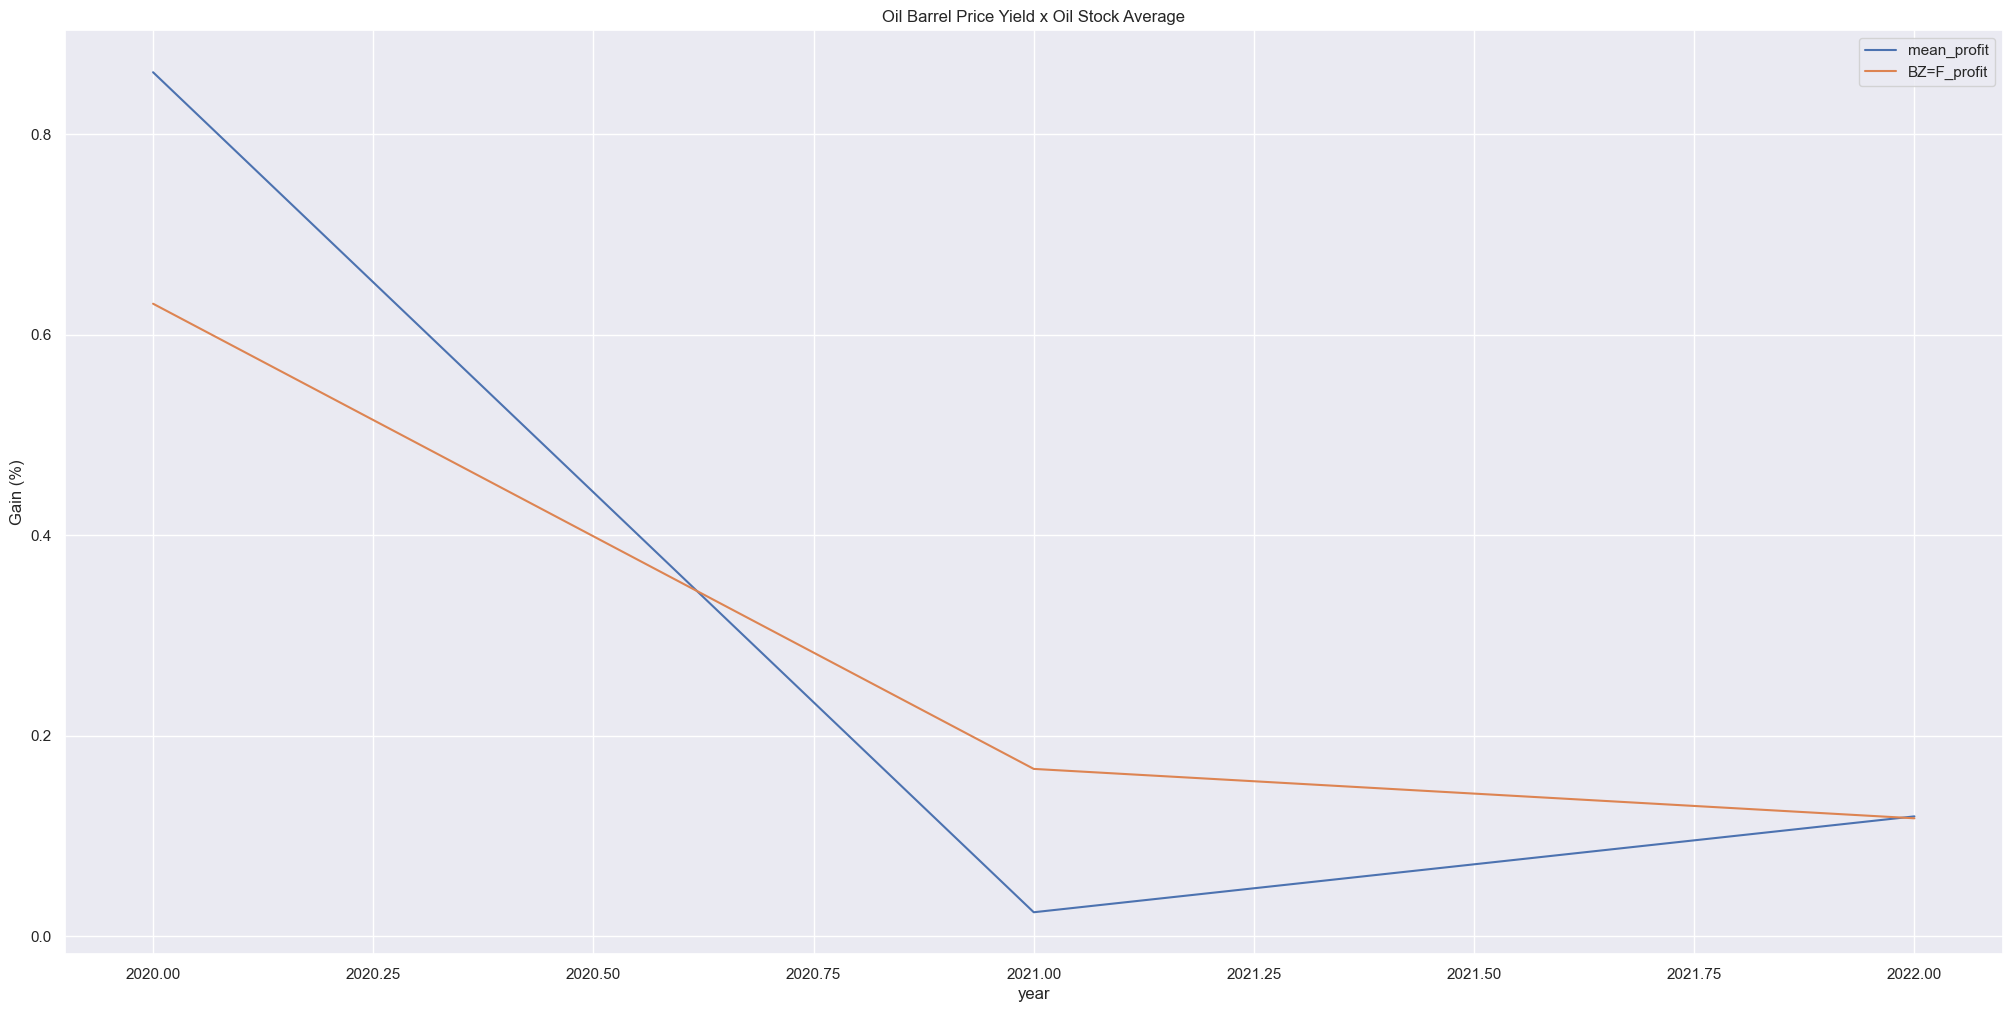

In [27]:
plt.figure(figsize=(22,8))
aux1 = aux.groupby('year').mean().reset_index()[['year', 'mean_profit']]

ax = aux1.plot(x='year')

aux2 = aux.groupby('year').mean().reset_index()[['year', 'BZ=F_profit']]
aux2.plot(x='year', ax=ax)
plt.title('Oil Barrel Price Yield x Oil Stock Average')
plt.ylabel('Gain (%)');

- It is possible to see that in the three years both the values of the returns between the average of the oil stocks and the price of a barrel of oil follow a trend

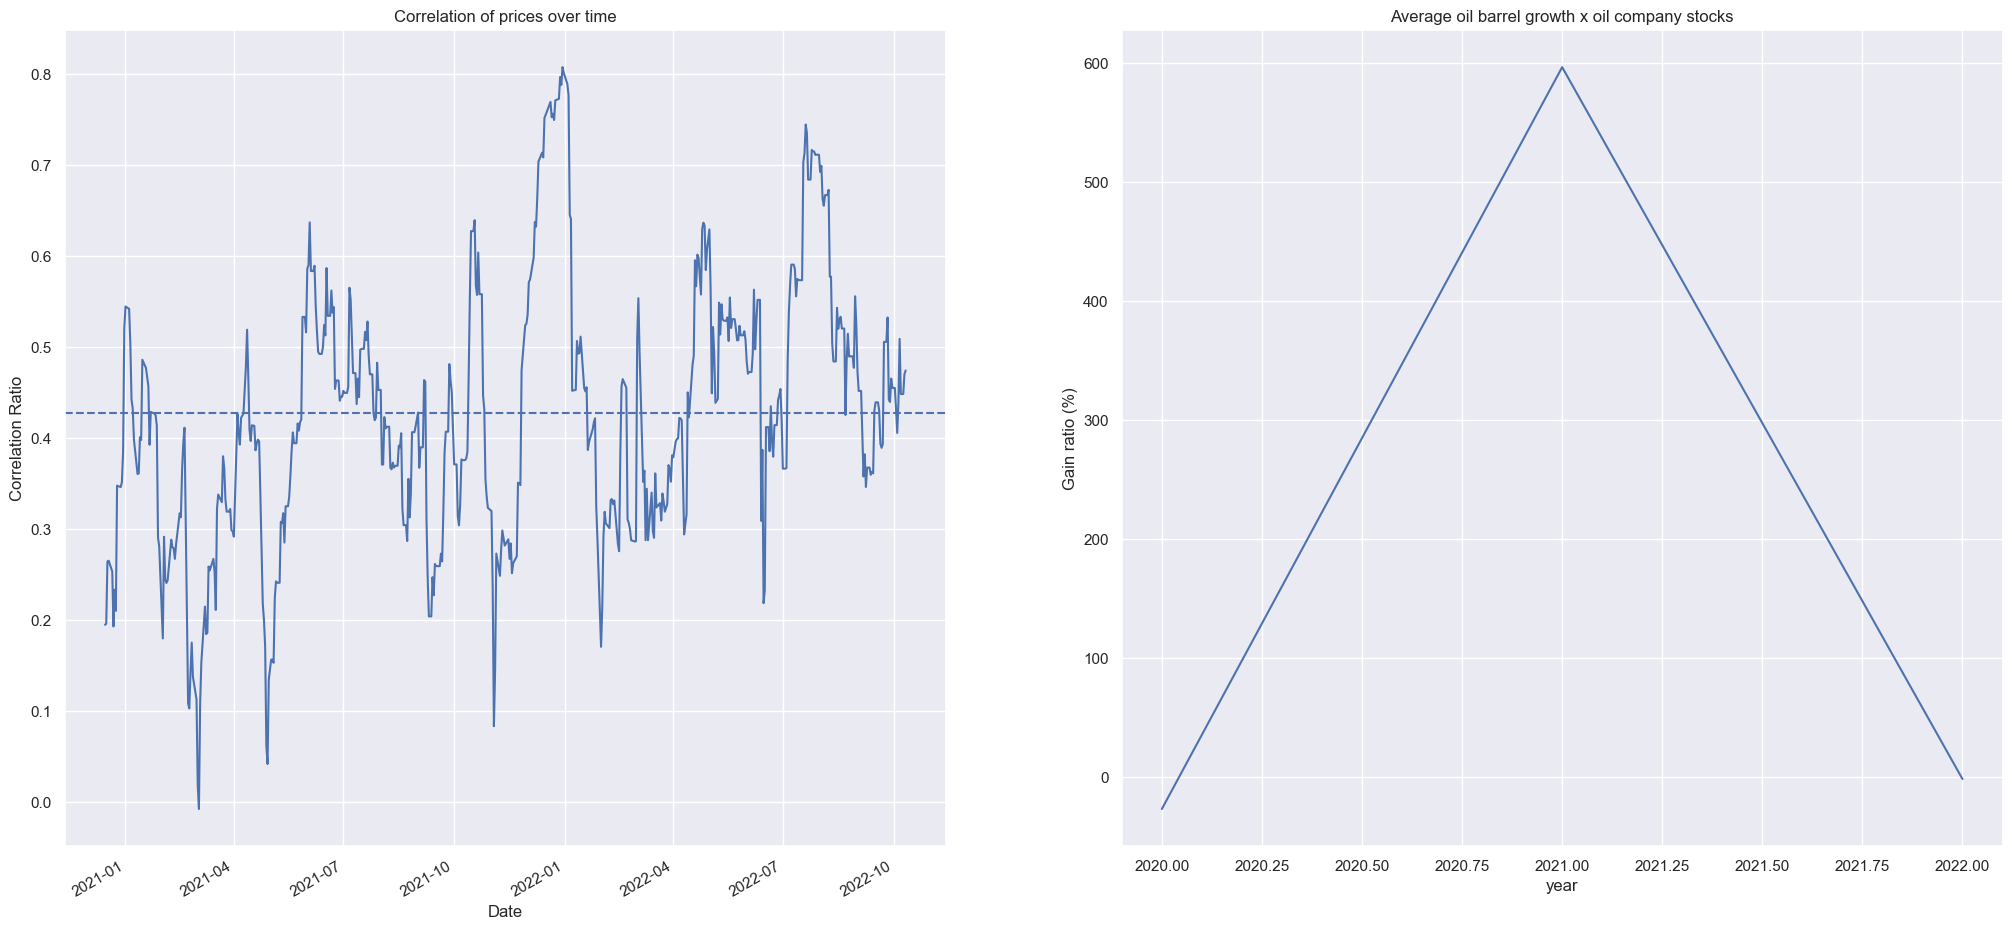

In [28]:
plt.subplot(1, 2, 1)
aux['mean_profit'].rolling(30).corr(aux['BZ=F_profit']).plot()
mean_corr = aux['mean_profit'].rolling(30).corr(aux['BZ=F_profit']).mean()

plt.axhline(mean_corr, linestyle='--')
plt.title('Correlation of prices over time')
plt.ylabel('Correlation Ratio');


plt.subplot(1, 2, 2)
aux3 = aux.groupby('year').mean().reset_index()[['year', 'mean_profit', 'BZ=F_profit']]

aux3['proportion'] = aux3['BZ=F_profit'] / aux3['mean_profit'] * 100 - 100

sns.lineplot(x='year', y='proportion', data=aux3)

plt.title('Average oil barrel growth x oil company stocks')
plt.ylabel('Gain ratio (%)');

- (1 Figure) The correlation between prices fluctuates considerably over time, averaging 0.4, typically a weak correlation.
- (2 Figure) In this chart it is possible to see that from 2020 to 2021 the barrel price appreciation against oil companies has a jump, but between 2021 and 2022 the difference adjusts

In [29]:
aux3

,year,mean_profit,BZ=F_profit,proportion
0,2020,0.86,0.63,-26.79
1,2021,0.02,0.17,596.56
2,2022,0.12,0.12,-1.62


- We can't see a linear growth trend, so we will take a 3-year average.

In [30]:
# Average growth 
aux3[['mean_profit', 'BZ=F_profit']].mean()

mean_profit   0.34
BZ=F_profit   0.31
dtype: float64

- On average the barrel price appreciates 8.82% less than the share price in the oil and gas industry.

### H2. O crescimento médio do preço de gás natural mensal (MoM) é 30% maior do que os das ações das empresas petrolíferas 
**TRUE** Em média o rendimento do preço de gás natural esteve 212,5% superior.

<Figure size 2200x800 with 0 Axes>

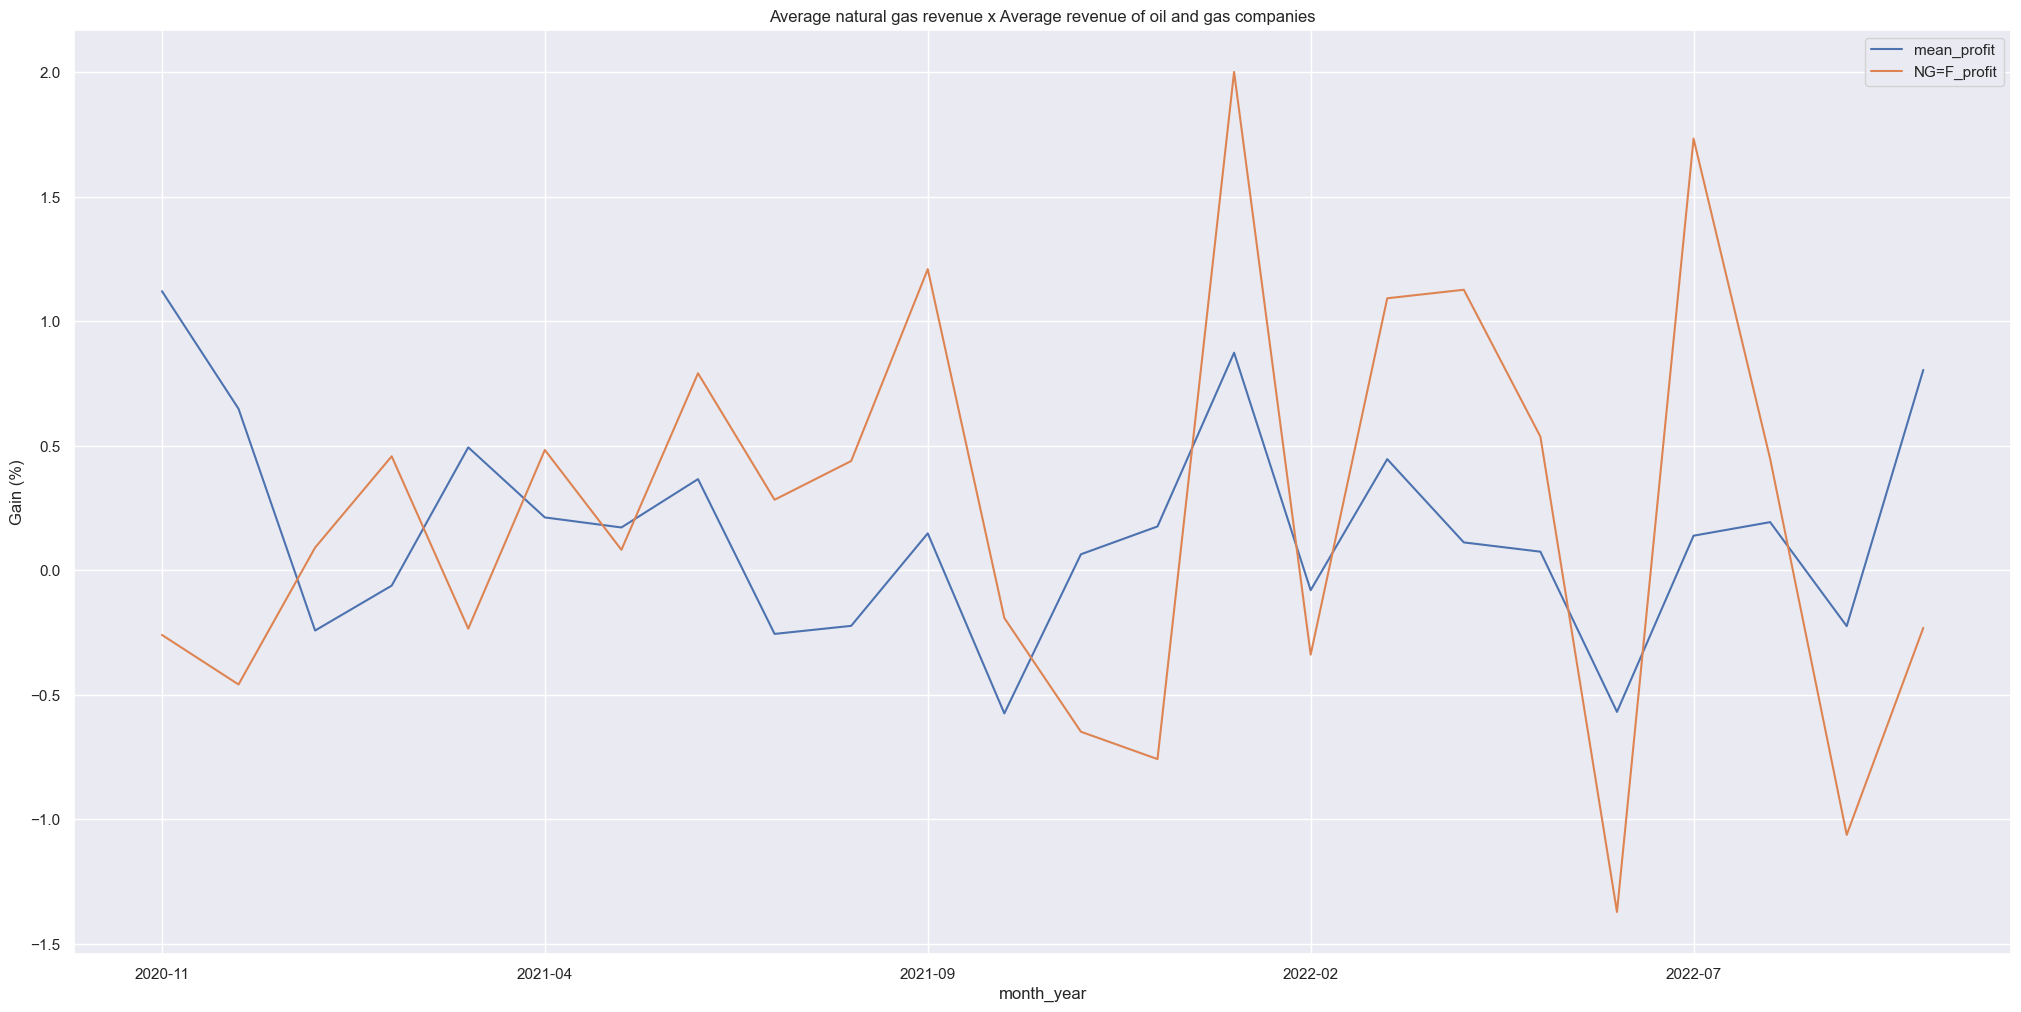

In [31]:
plt.figure(figsize=(22,8))

aux1 = aux.groupby('month_year').mean().reset_index()[['month_year', 'mean_profit']]

ax = aux1.plot(x='month_year')


aux2 = aux.groupby('month_year').mean().reset_index()[['month_year', 'NG=F_profit']]
aux2.plot(x='month_year', ax=ax)
plt.title('Average natural gas revenue x Average revenue of oil and gas companies')
plt.ylabel('Gain (%)');

- Both do not appear to have high correlations or trends

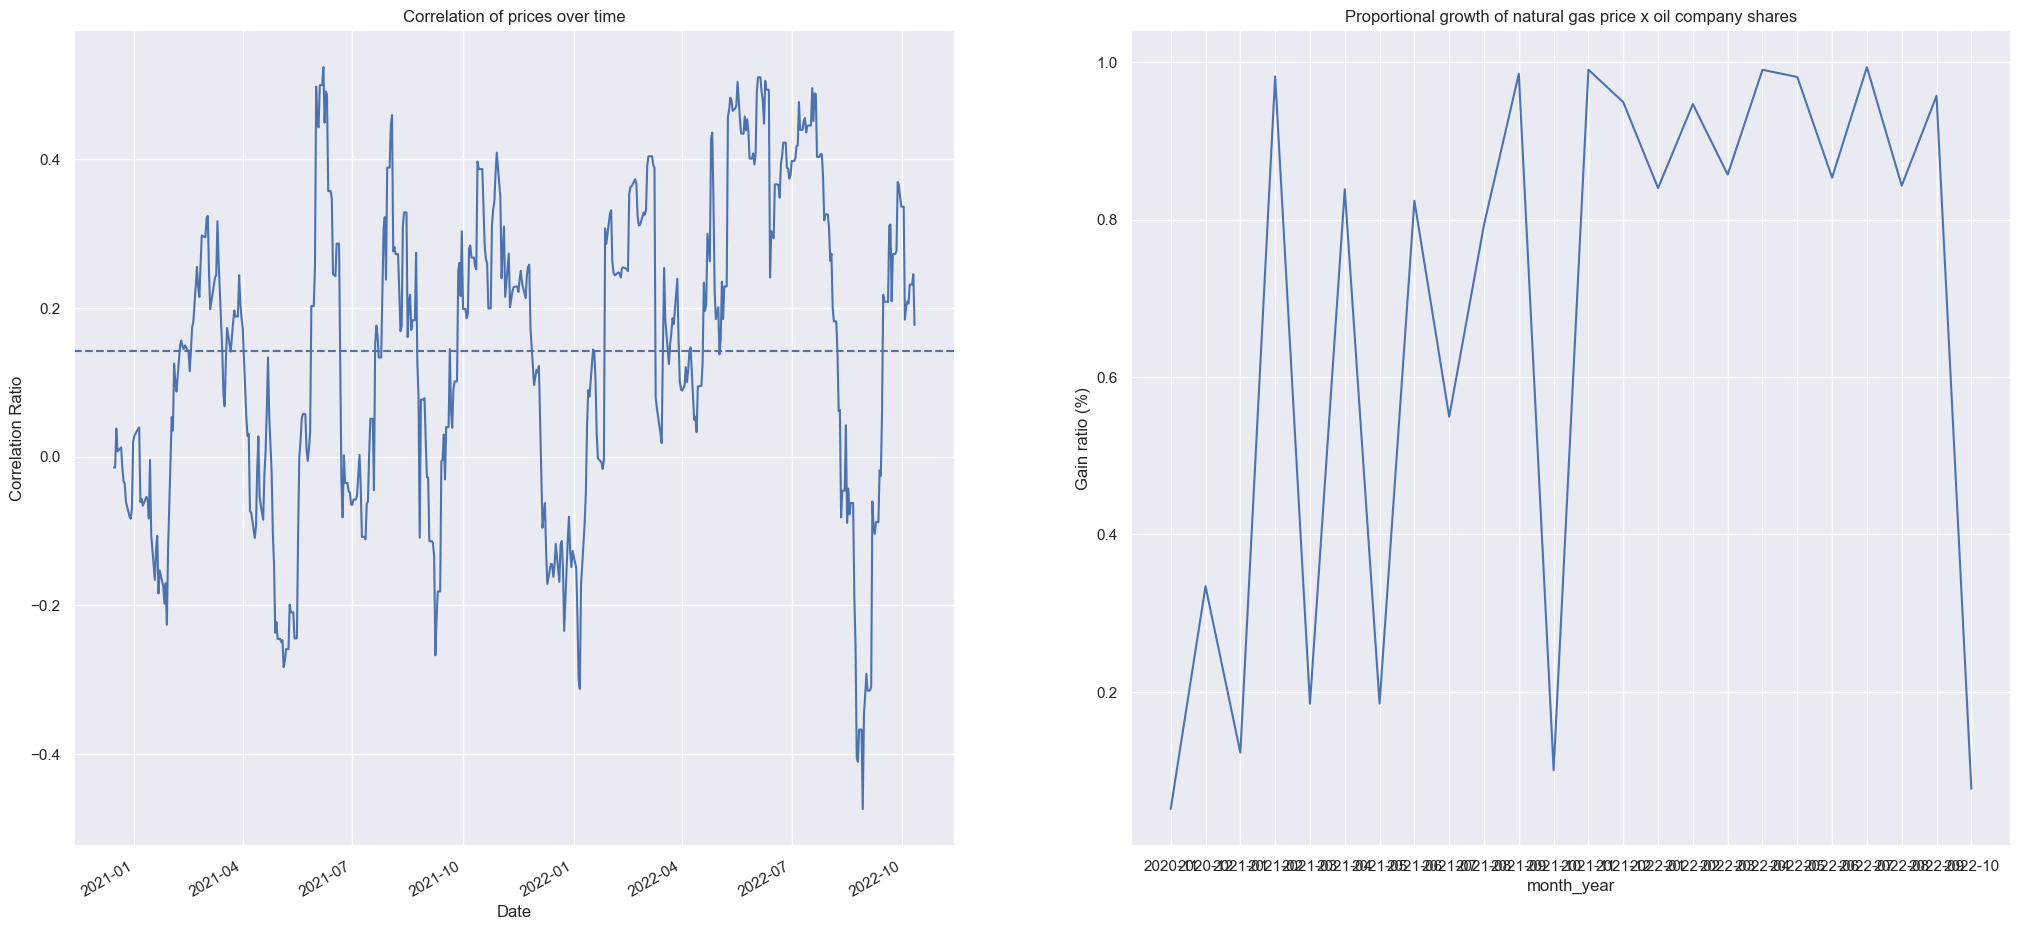

In [32]:
plt.subplot(1, 2, 1)
aux['mean_profit'].rolling(30).corr(aux['NG=F_profit']).plot()
mean_corr = aux['mean_profit'].rolling(30).corr(aux['NG=F_profit']).mean()

plt.axhline(mean_corr, linestyle='--')
plt.title('Correlation of prices over time')
plt.ylabel('Correlation Ratio');


plt.subplot(1, 2, 2)
aux2 = aux.groupby('month_year').mean().reset_index()[['month_year', 'mean_profit', 'NG=F_profit']]

aux2['proportion'] = aux2['NG=F_profit'] / aux2['mean_profit'] * 100 - 100

aux3 = aux2[['mean_profit', 'NG=F_profit']].apply(lambda x: x*x, axis=1)
aux3['sum'] = aux3.sum(axis=1)
aux3['month_year'] = aux2['month_year']
aux3['mean_profit_perc'] = aux3.apply(lambda x: x['mean_profit'] / x['sum'], axis=1)
aux3['NG=F_profit_perc'] = aux3.apply(lambda x: x['NG=F_profit'] / x['sum'], axis=1)

sns.lineplot(x='month_year',  y='NG=F_profit_perc', data=aux3);

plt.title('Proportional growth of natural gas price x oil company shares')
plt.ylabel('Gain ratio (%)');

- (Figure 1) No strong correlation is shown with daily data, the average value is 0.14.
- (Figure 2) It represents a strong percentage increase in natural gas yield compared to stocks, however we have a lot of oscillations, so we need an average.

In [33]:
aux3[['mean_profit_perc', 'NG=F_profit_perc']].mean()

mean_profit_perc   0.32
NG=F_profit_perc   0.68
dtype: float64

- We have in conclusion the average percentage of earnings from stocks and natural gas, with the highlight being gas, which comprises double the earnings.

### H3. Início de períodos de guerras correspondem a um aumento médio de 40% das ações. 
**TRUE** Os dois primeiros meses da guerra russo-ucraniana refletiram em valorização de aproximadamente 40% do valor das ações, entretanto não é possível afirmar que todas as guerras possuem mesmos efeitos.

Para essa análise será considerada a guerra russo-ucraniana iniciada em 23 de Fevereiro de 2022

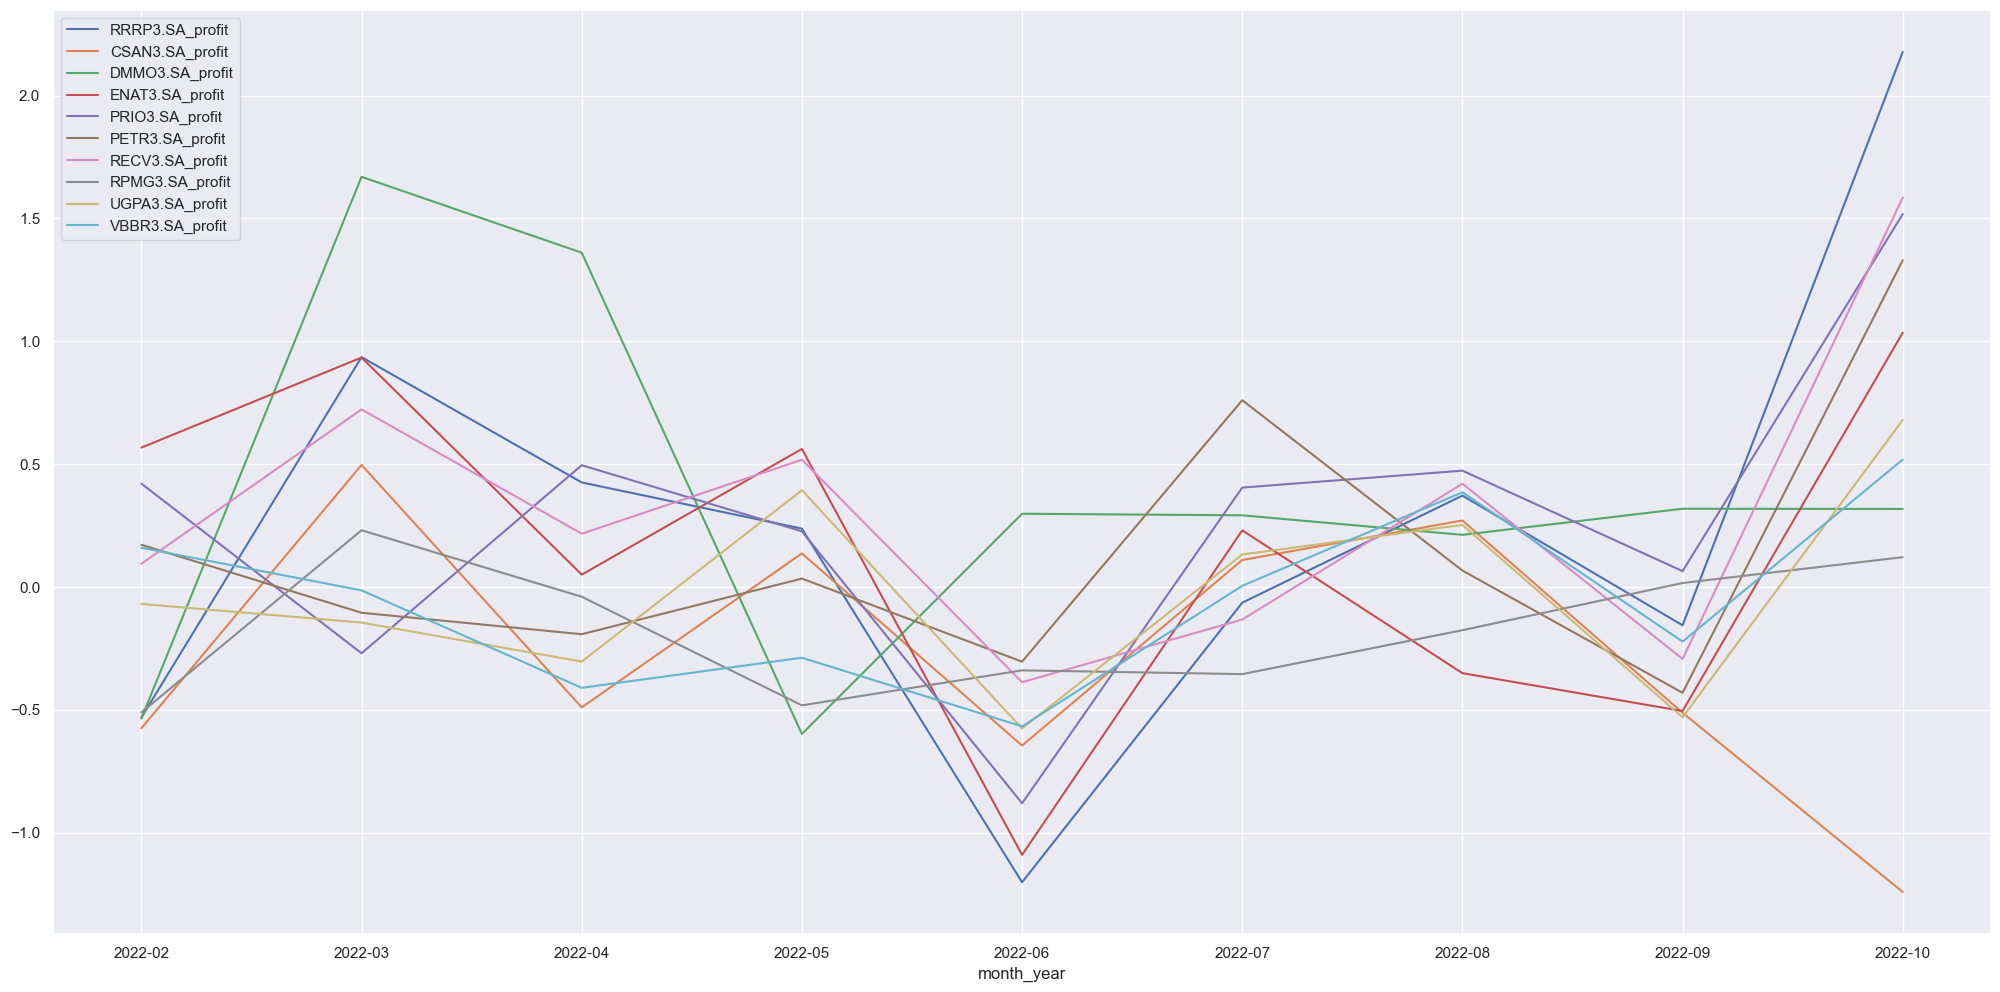

In [34]:
# Collecting Stock Yield Data for Individual Analysis
aux1 = df4[['RRRP3.SA_profit', 'CSAN3.SA_profit', 'DMMO3.SA_profit',
       'ENAT3.SA_profit', 'PRIO3.SA_profit', 'PETR3.SA_profit',
       'RECV3.SA_profit', 'RPMG3.SA_profit', 'UGPA3.SA_profit',
       'VBBR3.SA_profit', 'month_year']]

aux1 = aux1[aux1['month_year'] >= '2022-02']

aux1.groupby('month_year').mean().reset_index().set_index('month_year').plot();

- Due to the fluctuations of each paper it is difficult to see clearly if there has been a direct impact, you will need to use a paper that represents the shares of oil and gas companies.

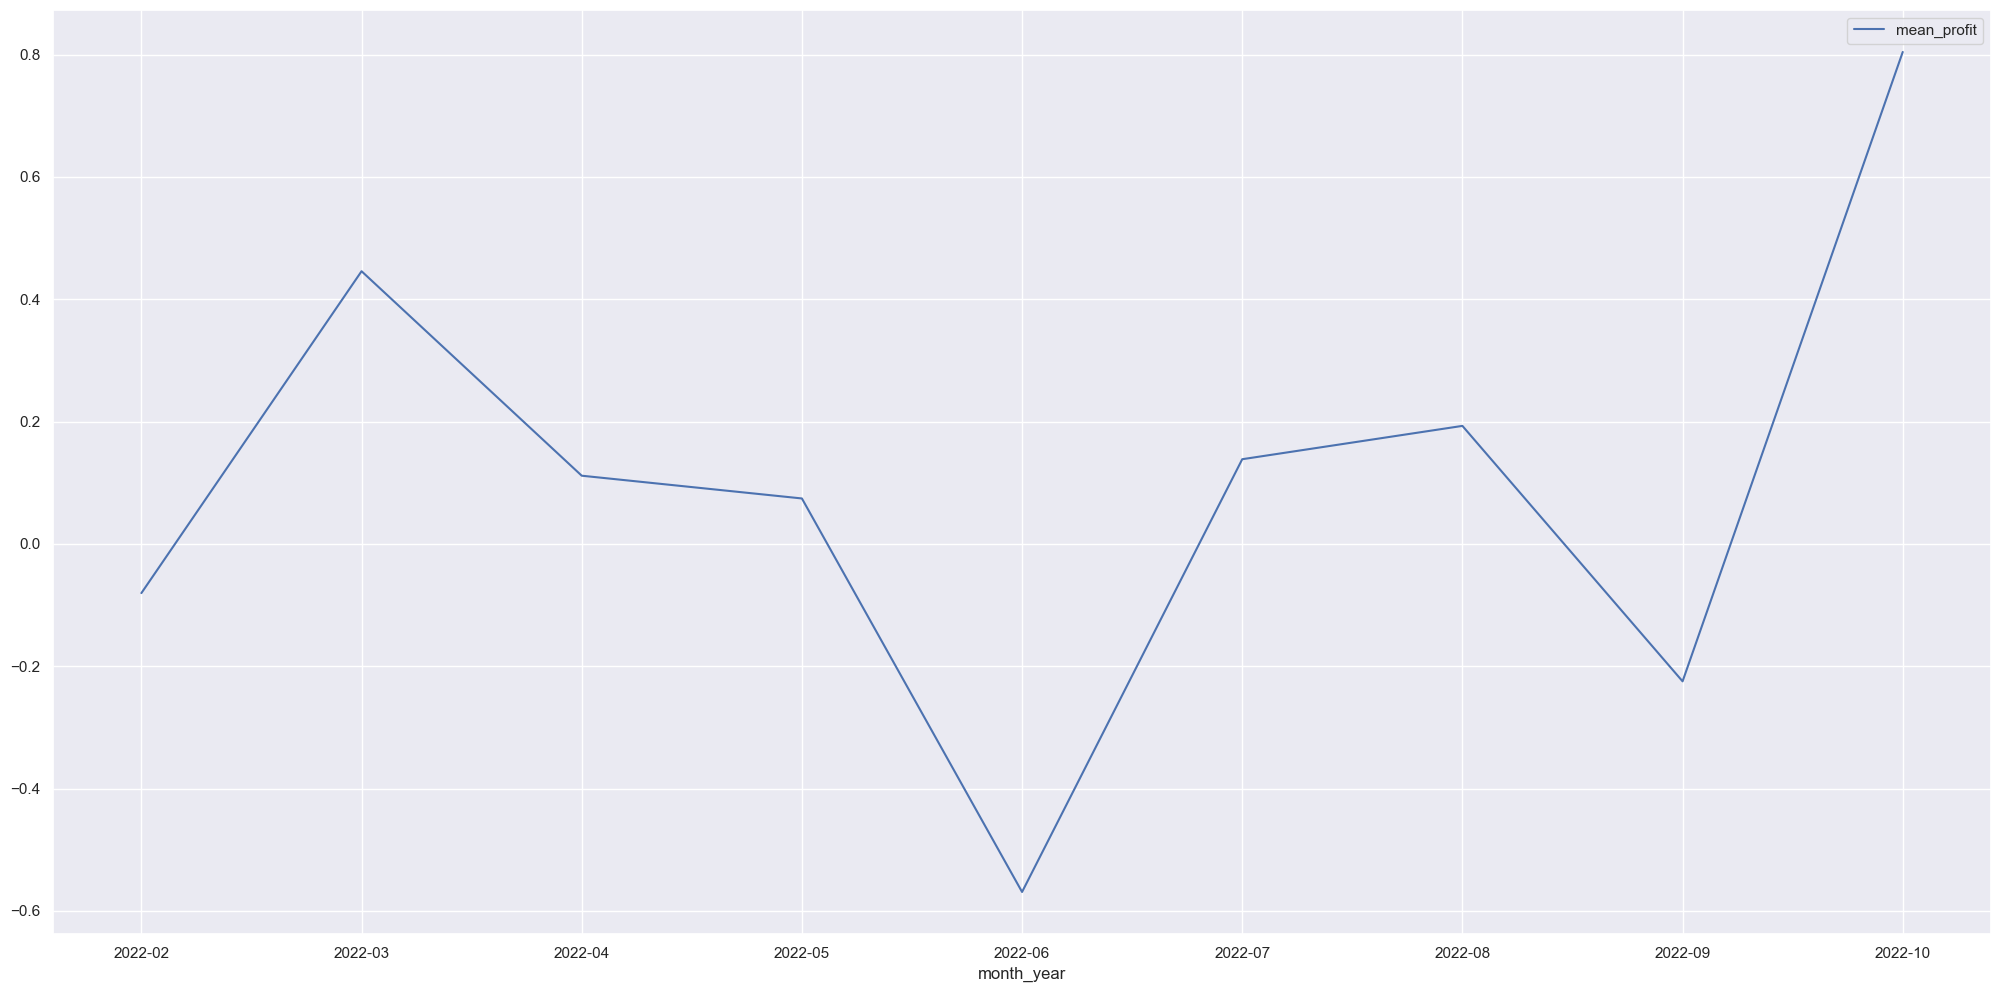

In [35]:
aux1 = aux[aux['month_year'] >= '2022-02']

aux1 = aux1[['month_year', 'mean_profit']].groupby('month_year').mean().reset_index()

aux1.set_index('month_year').plot();

In [36]:
aux1

,month_year,mean_profit
0,2022-02,-0.08
1,2022-03,0.45
2,2022-04,0.11
3,2022-05,0.07
4,2022-06,-0.57
5,2022-07,0.14
6,2022-08,0.19
7,2022-09,-0.22
8,2022-10,0.80


- It is possible to see that immediately (month 02) there was no difference observing an average, however in the following month we had an impact of 45% in the increase of the value.

### H4. Em média as ações de empresas de petróleo e gás crescem 5% a mais do que a inflação.
**FALSE** A inflação cresce significativamente mais do que o preço das ações

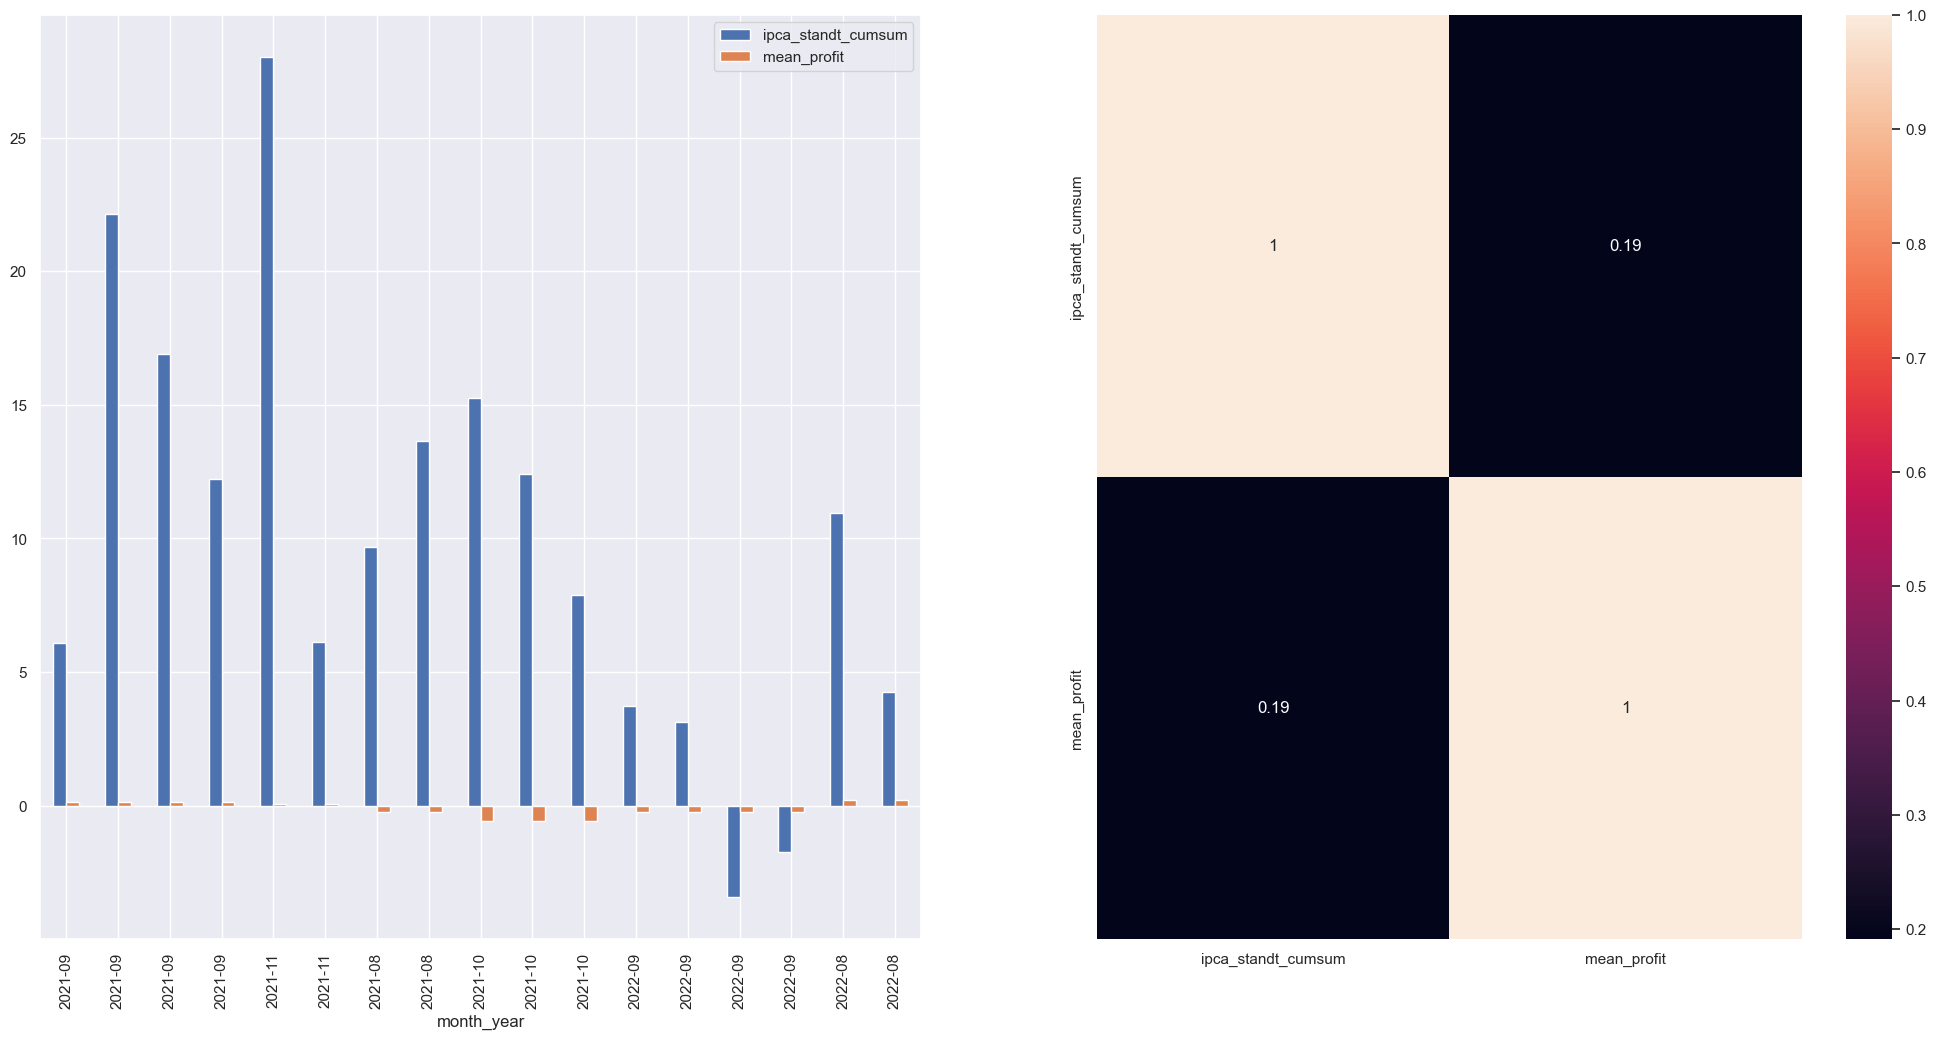

In [37]:
aux1 = aux[['month_year', 'mean_profit']].groupby('month_year').mean().reset_index()

aux1 = pd.merge(df_ipca, aux1, how='inner', on='month_year')

aux1 = aux1.tail(17)

ax = plt.subplot(1, 2, 1)

aux1[['ipca_standt_cumsum', 'month_year', 'mean_profit']].plot(x='month_year', kind='bar', ax=ax)

plt.subplot(1, 2, 2)
sns.heatmap(aux1[['ipca_standt_cumsum', 'mean_profit']].corr(), annot=True);

- (Figure 1) Even when normalized, it is difficult to see the impact of inflation on stocks, but it is significant enough to say that inflation has a greater impact on stocks.
- (Figure 2) The correlation value indicates that the variables are practically uncorrelated.

### H5. Em períodos trimestrais onde o Real desvaloriza em media 5% as ações valorizam em média 10%.
**TRUE** Em média para 7% de desvalorização do real as ações valorizam em média 27%.

In [38]:
aux['quarter'] = aux['month'].apply(lambda x: 4 if x >= 10 else 3 if x >= 7 else 2 if x >= 4 else 1)

C:\Users\SamuelOliveiraAlvesd\AppData\Local\Temp\ipykernel_19780\1636315626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['quarter'] = aux['month'].apply(lambda x: 4 if x >= 10 else 3 if x >= 7 else 2 if x >= 4 else 1)


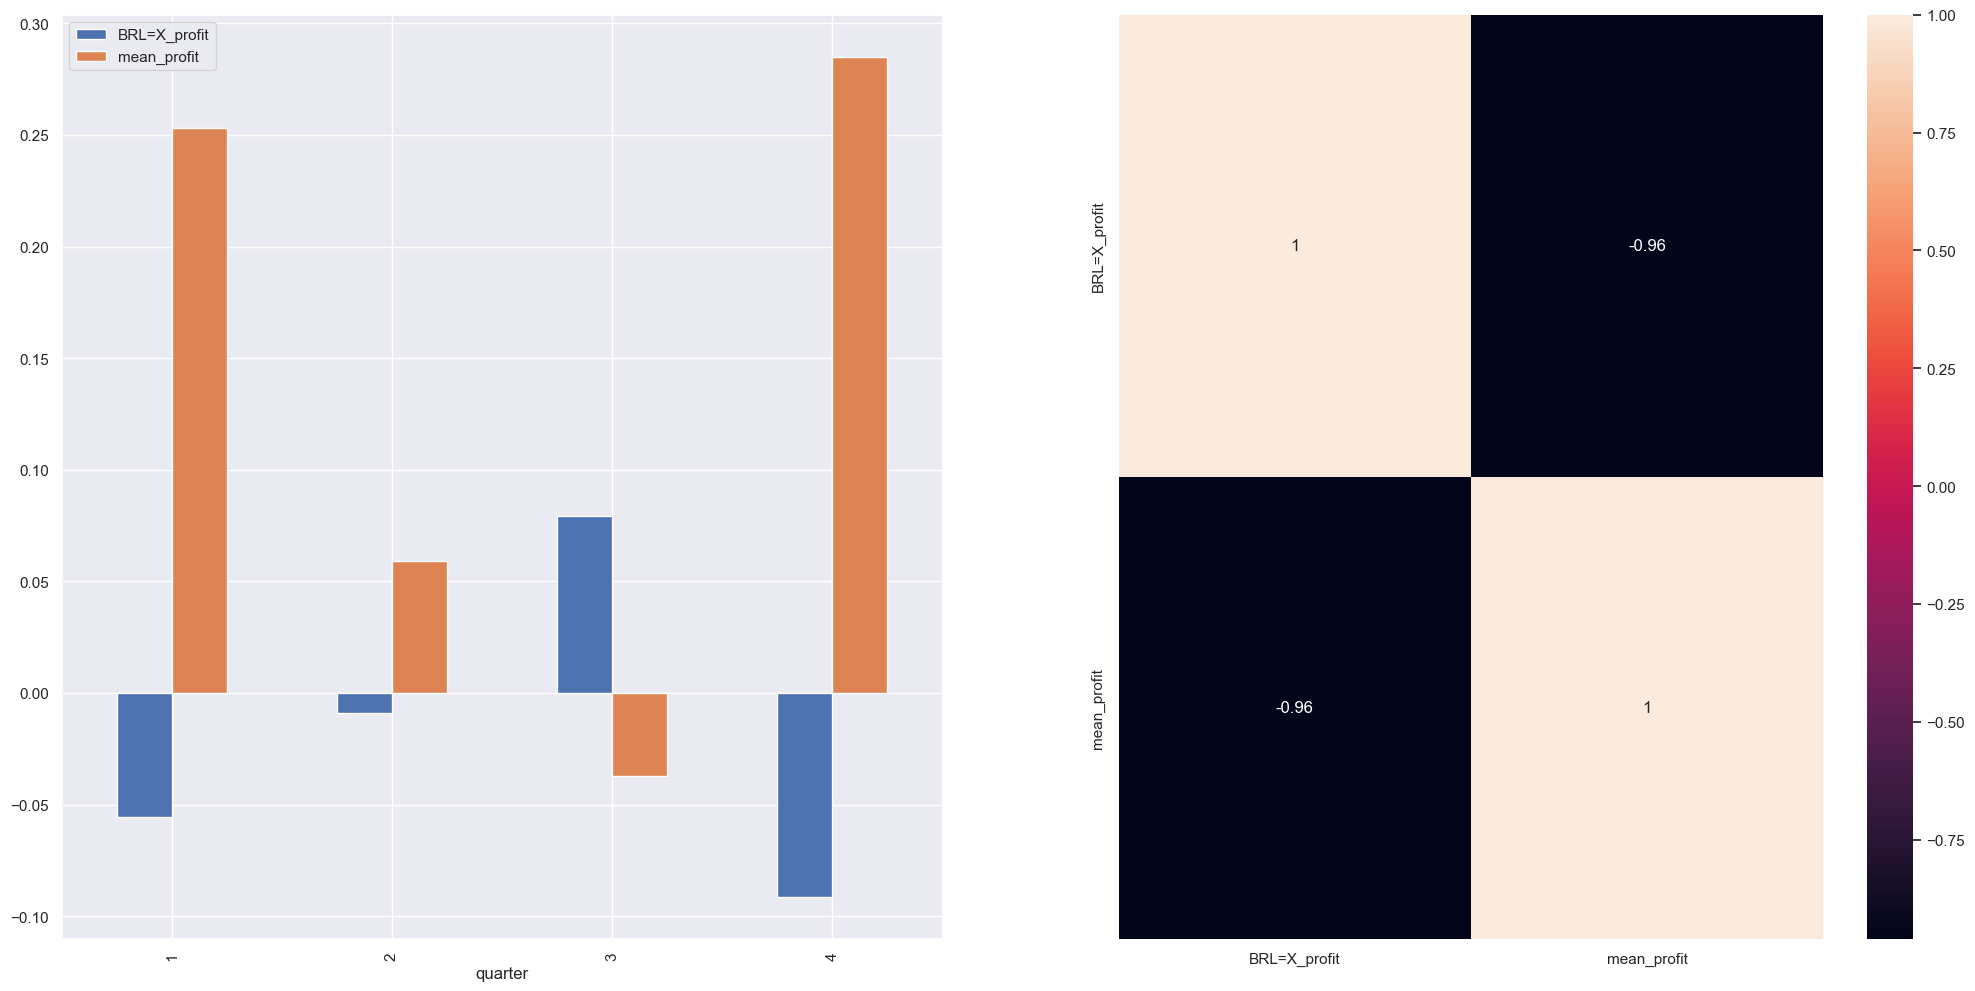

In [39]:
aux1 = aux[['BRL=X_profit', 'mean_profit', 'quarter']].groupby('quarter').mean()

ax = plt.subplot(1, 2, 1)
aux1.plot(kind='bar', ax=ax);

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(),annot=True);

- You can see the inverse correlation that matches the hypothesis, the second figure shows a strong correlation.

In [40]:
aux1

,BRL=X_profit,mean_profit
quarter,,
1,-0.06,0.25
2,-0.01,0.06
3,0.08,-0.04
4,-0.09,0.29


In [41]:
aux1[aux1['mean_profit'] >= 0.2].mean()

BRL=X_profit   -0.07
mean_profit     0.27
dtype: float64

- We have two situations where it is possible to validate the hypothesis: 
1. In the 1st quarter, for a 6% drop in the real, the stock appreciates 25%.
2. In the 4th quarter, for a 9% drop in the real, the share appreciates 29%.

Finally for each 7% devaluation we have 27% appreciation.

### 4.2.1 Resumo das Hipóteses

In [42]:
tab = [['Hipóteses', 'Conclusão'],
       ['H1', 'Falsa'],
       ['H2', 'Verdadeira'],
       ['H3', 'Verdadeira'],
       ['H4', 'Falsa'],
       ['H5', 'Verdadeira'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão
-----------  -----------
H1           Falsa
H2           Verdadeira
H3           Verdadeira
H4           Falsa
H5           Verdadeira


## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos

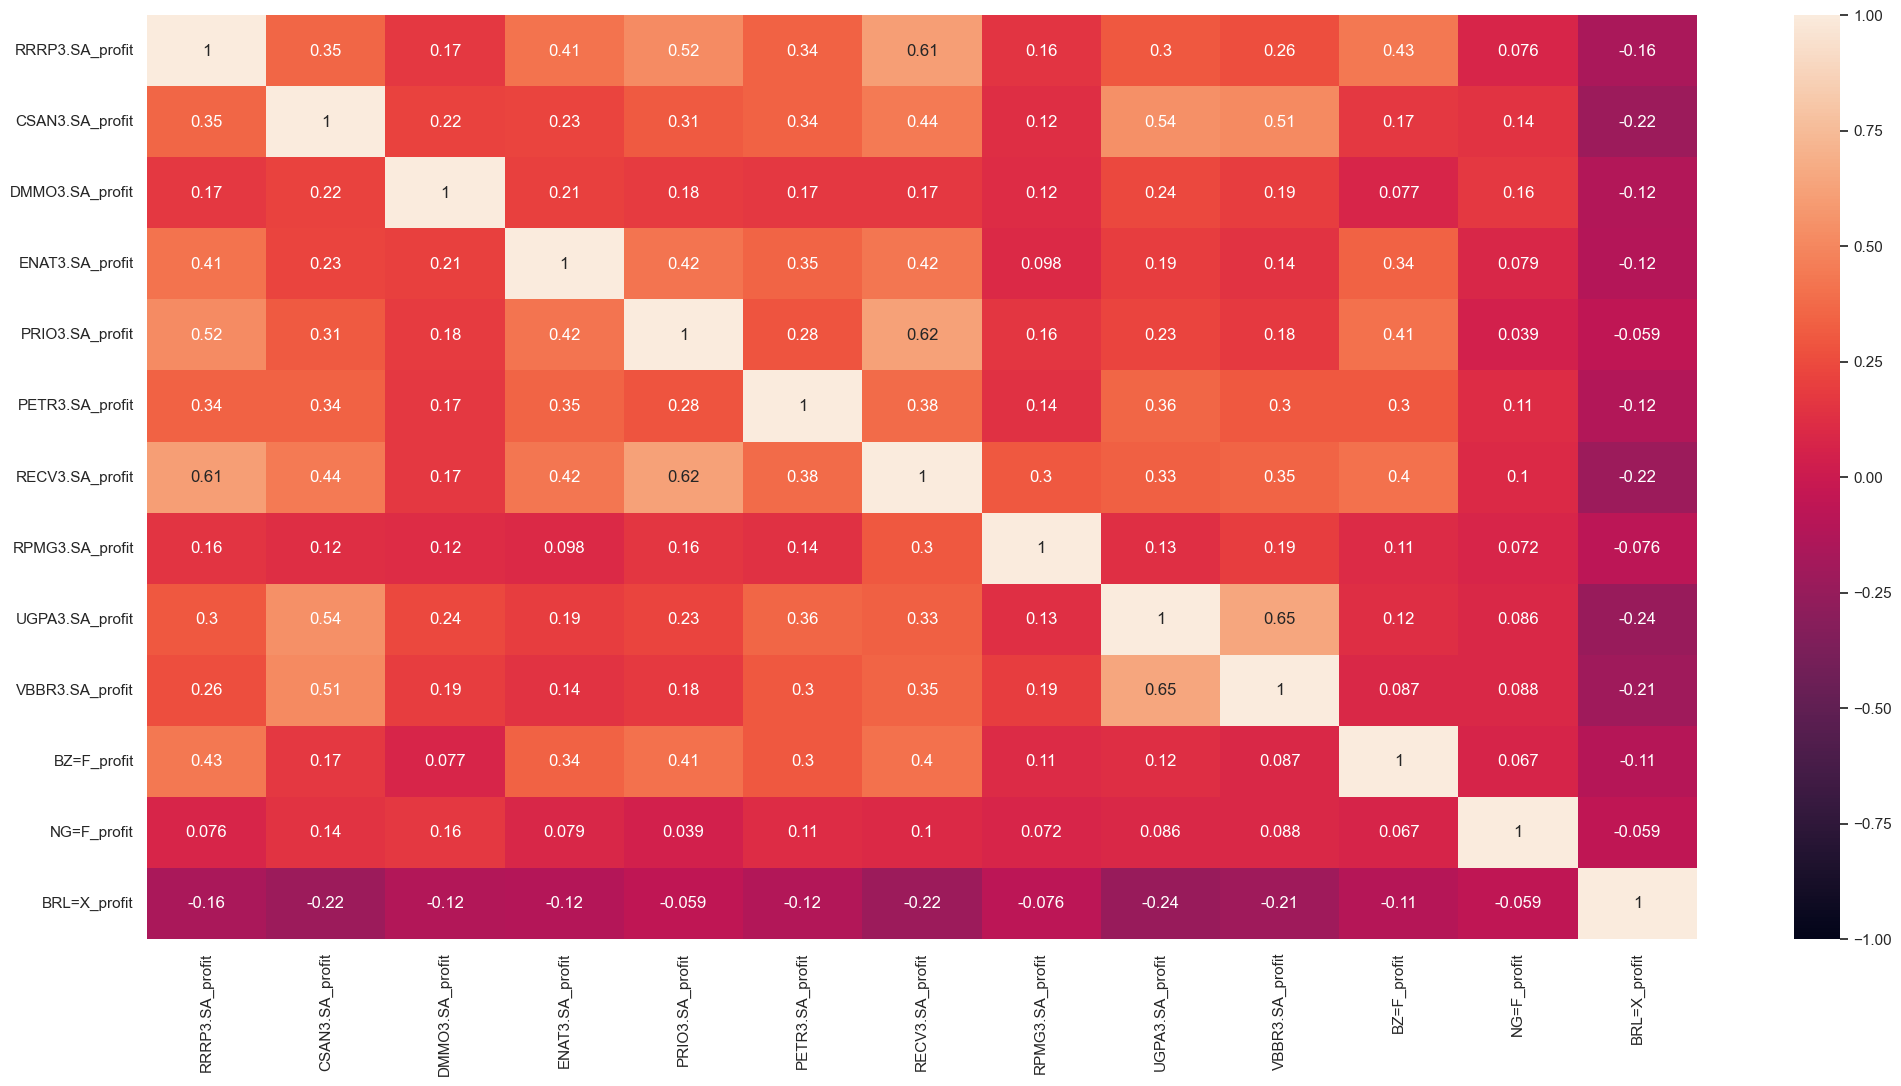

In [43]:
corr_list = ['RRRP3.SA_profit', 'CSAN3.SA_profit', 'DMMO3.SA_profit',
            'ENAT3.SA_profit', 'PRIO3.SA_profit', 'PETR3.SA_profit',
            'RECV3.SA_profit', 'RPMG3.SA_profit', 'UGPA3.SA_profit',
            'VBBR3.SA_profit', 'BZ=F_profit', 'NG=F_profit', 'BRL=X_profit']
            
sns.heatmap(df4[corr_list].corr(method='pearson'), annot=True, vmin=-1);

- Overall we have few strong correlations, although they are stocks from the same sector the volatility is probably linked to other external factors not captured by this data collection.